In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import Galactic, ICRS
from astropy import units as u
from modules.vr_opt import VrOpt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import normalized_mutual_info_score
import hdbscan

In [2]:
#!source /Users/lui/Documents/3_semestr/Project/env_project/env_project_dap/bin/activate

## Identifying clusters in the 100 pc sphere

<span style="font-size:18px;">

* Clustering in the 100 pc sphere is a challenging task.
* The data is un-evenly dense in two respective subspaces. Especially the velocity space is subject to strong non-linear projection effects.
* An originally compact Gaussian point cloud can result in a highly non-convex shape in the velocity space.

Let's see what this might look like in practice.

</span>

In [3]:
# Plotting related stuff
alphas = [0.9, 0.9, 0.3]
colors = ['tab:red', 'tab:blue', 'tab:grey']
zorders = [1, 1, 0]
log = True

In [4]:
# Create 6D Gaussian data
n = 500 #1000
X_bg = (np.random.rand(n*5, 6) - 0.5) * 50

mu = np.array([-5, 5, 5, 5, -5, 5])
c_xx = c_yy = 20
c_xy = 15
c_zz = 3
c_uvw = 1
cov = np.diag([c_xx, c_yy, c_zz, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy
# Add signal
X_sig_1 = np.random.multivariate_normal(mu, cov, n//2)

# Second cluster
mu_2 = np.array([5, -5, -5, -5, 5, -5])
c_xx_2 = c_yy = 20
c_xy_2 = -15
c_zz_2 = 3
cov = np.diag([c_xx_2, c_yy, c_zz_2, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy_2
X_sig_2 = np.random.multivariate_normal(mu_2, cov, n//2)

X = np.concatenate([X_bg, X_sig_1, X_sig_2], axis=0)
labels = np.concatenate([np.zeros(n*5), np.ones(n//2), np.ones(n//2)*2])

df = pd.DataFrame(X, columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])
# Transform to spherical coordinates
gal_coords = Galactic(
    u=df.x.values * u.pc,
    v=df.y.values * u.pc,
    w=df.z.values * u.pc,
    # velocities UVW
    U=df.vx.values * u.km / u.s,
    V=df.vy.values * u.km / u.s,
    W=df.vz.values * u.km / u.s,
    representation_type="cartesian",
    # Velocity representation
    differential_type="cartesian",
)
# transform to ICRS
icrs_coords = gal_coords.transform_to(ICRS())
icrs_coords.representation_type = "spherical"

ra = icrs_coords.ra.value
dec = icrs_coords.dec.value
dist = icrs_coords.distance.value
pmra = icrs_coords.pm_ra.value * np.cos(np.deg2rad(dec))
pmdec = icrs_coords.pm_dec.value
rv_calc = icrs_coords.radial_velocity.value

df['ra'] = ra
df['dec'] = dec
df['dist'] = dist
df['pmra'] = pmra
df['pmdec'] = pmdec
df['radial_velocity'] = rv_calc

df['vt_ra'] = df.pmra * df.dist * 4.74
df['vt_dec'] = df.pmdec * df.dist * 4.74

idx_cluster_1 = np.where(labels==1)[0]
idx_cluster_2 = np.where(labels==2)[0]
idx_bg = np.where(labels==0)[0]

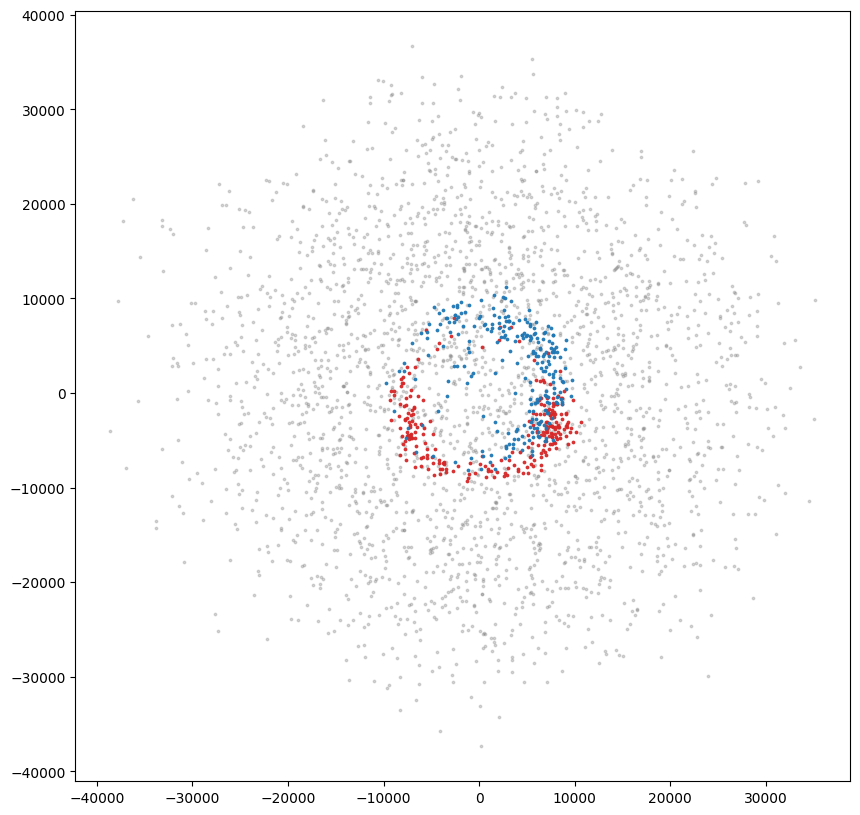

In [5]:
# x_col, y_col = 'x', 'y'
# x_col, y_col = 'vx', 'vy'
x_col, y_col = 'vt_ra', 'vt_dec'
# x_col, y_col = 'pmra', 'pmdec'

fig = plt.figure(figsize=(10, 10))
for idx_sel, alpha, c, zo in zip([idx_cluster_1, idx_cluster_2, idx_bg], alphas, colors, zorders):
    # if c == 'tab:blue':
    plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, c=c, alpha=alpha, zorder=zo)
    
# plt.xlim(-1000, 1000)
# plt.ylim(-1000, 1000)

# Optimal radial velocity class
VrOpt computes pairwise minimal 3D velocity difference (in Cartesian space) for a given set of stars.

In [6]:
est = VrOpt(ra, dec, pmra, pmdec, dist)

# Now built the distance matrix for clustering ourselves

In [7]:
# # Lower triangular matrix indices
a, b = np.tril_indices(len(X), -1)
_, _, delta_v = est.vr_opt(a, b)

# Create pairwise distance matrix with delta_v entries
dist_v_opt = np.zeros((len(X), len(X)))
dist_v_opt[a, b] = delta_v
dist_v_opt[b, a] = delta_v

## Compute the semi-cohesion metric

<span style="font-size:18px;">

Given a semi-metric d(·,·) for $\Omega$, we define the induced semi-cohesion measure as follows:

$$ g(x, y) = \frac{1}{n} \sum_{z_2 \in \Omega} d(z_2, y) + \frac{1}{n} \sum_{z_1 \in \Omega} d(x, z_1) - \frac{1}{n^2}  \sum_{z_2 \in \Omega} \sum_{z_1 \in \Omega} d(z_2, z_1) - d(x, y) $$ 

</span>


In [8]:
# Compute semi-cohesion metric G
G = np.copy(dist_v_opt)
G = np.full_like(G, np.sum(G, axis=0)/len(G)) + np.full_like(G, np.sum(G, axis=0)/len(G)).T - np.sum(G)/len(G)**2 - G

In [9]:
G

array([[ 26.3564047 ,  11.0989376 ,  14.71493323, ...,  -8.73820325,
          9.66877837,  -8.31731371],
       [ 11.0989376 ,  17.65614598,  -8.3706649 , ...,  -4.09213312,
          3.59981006,  -7.02266189],
       [ 14.71493323,  -8.3706649 ,  24.90226418, ...,  12.1737474 ,
         -2.44175532, -12.52476569],
       ...,
       [ -8.73820325,  -4.09213312,  12.1737474 , ...,   7.83859336,
          5.45734088,   5.86268847],
       [  9.66877837,   3.59981006,  -2.44175532, ...,   5.45734088,
          7.3667703 ,   5.4642764 ],
       [ -8.31731371,  -7.02266189, -12.52476569, ...,   5.86268847,
          5.4642764 ,   6.34345052]])

## Compute the semi-cohesion metric - direct way (just to see if I get the same results)

In [10]:
n = dist_v_opt.shape[0]

row_sum = np.sum(dist_v_opt, axis=1)  #Sum of distances for each row
col_sum = np.sum(dist_v_opt, axis=0)  #Sum of distances for each column

#Sum of all pairwise distances
total_sum = np.sum(dist_v_opt)  

#Semi-cohesion matrix G
G_direct = np.zeros_like(dist_v_opt)  

for i in range(n):
    for j in range(n):
        G_direct[i, j] = (row_sum[j] / n) + (col_sum[i] / n) - (total_sum / n**2) - dist_v_opt[i, j]


In [11]:
G_direct

array([[ 26.3564047 ,  11.0989376 ,  14.71493323, ...,  -8.73820325,
          9.66877837,  -8.31731371],
       [ 11.0989376 ,  17.65614598,  -8.3706649 , ...,  -4.09213312,
          3.59981006,  -7.02266189],
       [ 14.71493323,  -8.3706649 ,  24.90226418, ...,  12.1737474 ,
         -2.44175532, -12.52476569],
       ...,
       [ -8.73820325,  -4.09213312,  12.1737474 , ...,   7.83859336,
          5.45734088,   5.86268847],
       [  9.66877837,   3.59981006,  -2.44175532, ...,   5.45734088,
          7.3667703 ,   5.4642764 ],
       [ -8.31731371,  -7.02266189, -12.52476569, ...,   5.86268847,
          5.4642764 ,   6.34345052]])

In [12]:
np.allclose(G, G_direct) 

True

## Implement the K-sets+ algorithm

<span style="font-size:18px;">
Implement the K-sets+ algorithm from this paper that uses the above computed semi-cohesion metric, see [here](https://arxiv.org/pdf/1705.04249).

</span>

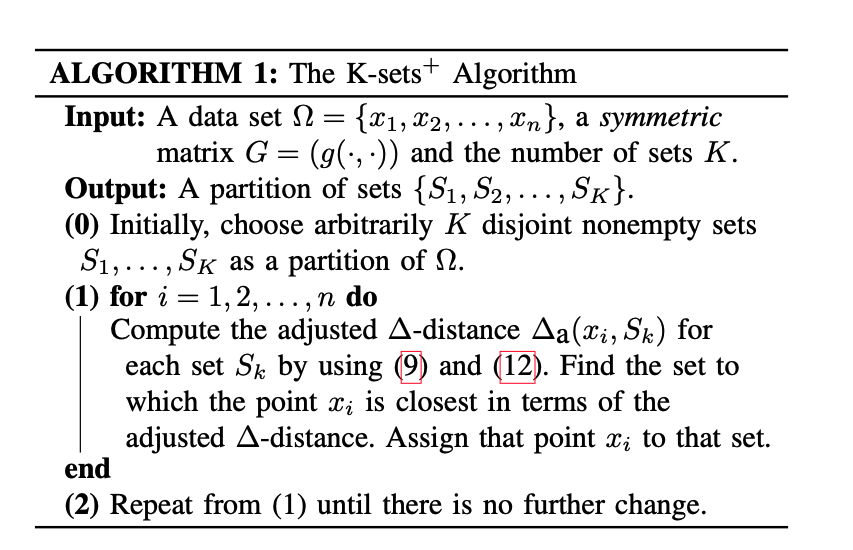

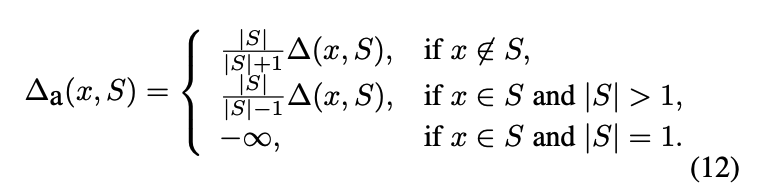

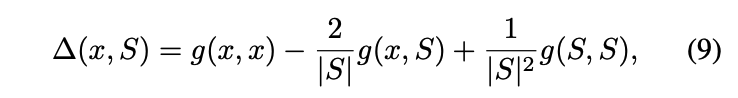

In [4]:
from IPython.display import display, Image
display(Image(filename='img/kset_alg.png'))
display(Image(filename='img/kset_alg2.png'))
display(Image(filename='img/kset_alg3.png'))

In [14]:
import time
from sklearn.cluster import KMeans

def ksets_plus(G, K, max_iter = 20, method = "random"):

    start_time = time.time()
    np.random.seed(42)
    n = G.shape[0]

    # Initial K disjoint sets
    if method == "random":
        sets = np.random.randint(0, K, size=n) 
    elif method == "kmeans":
        kmeans = KMeans(n_clusters=K, random_state=42)
        sets = kmeans.fit_predict(df[['x', 'y', 'z']].values)
    else:
        ValueError("Invalid method")
        
        
    for iteration in range(max_iter):
        changes = 0  # Track changes

        for i in range(n):
            best_cluster = sets[i]
            min_distance = np.inf

            for k in range(K):
                S_k = np.where(sets == k)[0]  # Get indices of all points in set
                
                if len(S_k) == 0:
                    continue  
                
                # Compute adjusted distance
                if i not in S_k:
                    # Point is outside set
                    distance = (len(S_k) / (len(S_k) + 1)) * (G[i, i] - 2 * G[i, S_k].sum() / len(S_k) + G[S_k][:, S_k].sum() / (len(S_k) ** 2))

                    # Point is inside set
                else:
                    if len(S_k) > 1:
                        distance = (len(S_k) / (len(S_k) - 1)) * (G[i, i] - 2 * G[i, S_k].sum() / len(S_k) + G[S_k][:, S_k].sum() / (len(S_k) ** 2))
                    else:
                        distance = -np.inf

                # Find the closest set
                if distance < min_distance:
                    min_distance = distance
                    best_cluster = k
            
            if sets[i] != best_cluster:
                sets[i] = best_cluster
                changes += 1

        # If no further changes => stop
        if changes == 0:
            break

    end_time = time.time()
    execution_time = end_time - start_time
    minutes = int(execution_time // 60)
    seconds = int(execution_time % 60)
    print(f'Execution time: {minutes} minutes and {seconds} seconds')
    print(f'Number of iterations {iteration + 1}')

    return sets

In [15]:
# Plotting clusters depending on x_col and y_col
def plot_clusters(df, cluster_labels, true_labels, K, x_col, y_col):
    fig, ax = plt.subplots(1, K, figsize=(5*K, 5))
    for l_i in np.unique(cluster_labels):
        if l_i != -1:
            idx_sel = cluster_labels == l_i
            ax[l_i].scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s = 3, alpha = 0.8, zorder = 1, c = true_labels[idx_sel])
            ax[l_i].set_xlabel(x_col)
            ax[l_i].set_ylabel(y_col)
    plt.tight_layout()
    plt.show()


In [16]:
K = 3  
labels_ksets_random = ksets_plus(G, K, method = "random")

Execution time: 10 minutes and 1 seconds
Number of iterations 20


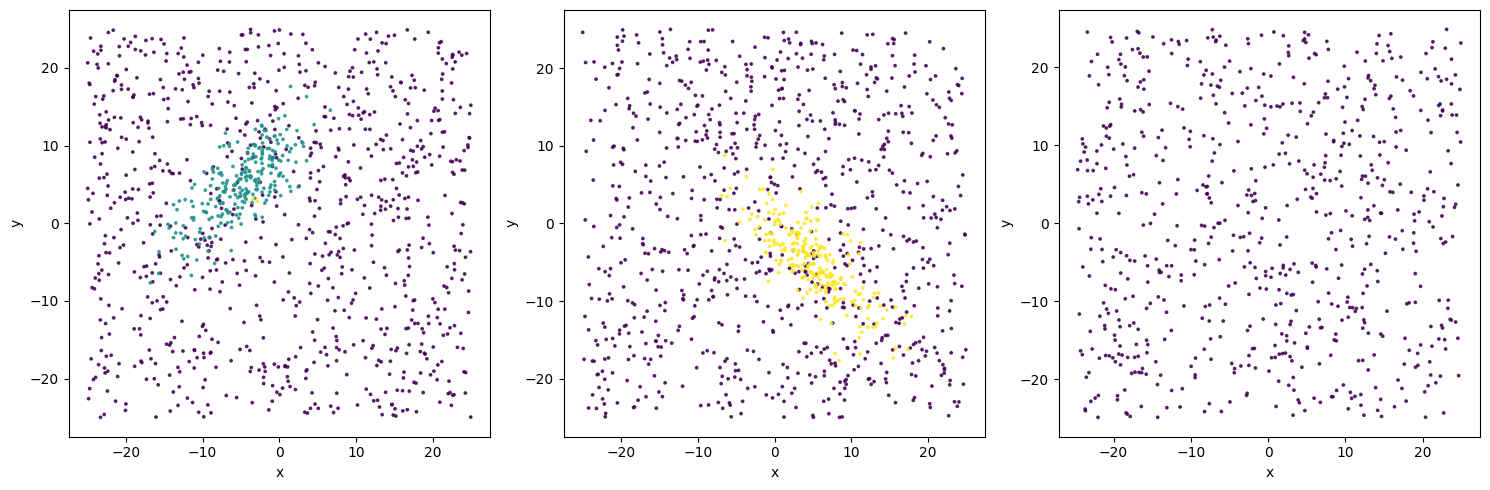

In [17]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'pmra', 'pmdec'
#x_col, y_col = 'vt_ra', 'vt_dec'
plot_clusters(df, labels_ksets_random, labels, K, x_col, y_col)

In [18]:
def ksets_plus_optimized(G, K, max_iter=100, method="random"):

    start_time = time.time()
    n = G.shape[0]
    np.random.seed(42)

    # Initialize K disjoint sets
    if method == "random":
        sets = np.random.randint(0, K, size=n)
    elif method == "kmeans":
        kmeans = KMeans(n_clusters=K, random_state=42)
        sets = kmeans.fit_predict(df[['x', 'y', 'z']].values)
    else:
        raise ValueError("Invalid method")
        

    for iteration in range(max_iter):
        
        changes = 0 # Track changes

        
        G_diag = np.diag(G) # Precompute diagonal of G, G[x,x]

        # Compute current cluster sizes |S| - necessary for computing adjusted distances
        cluster_sizes = np.array([np.sum(sets == k) for k in range(K)])

        # Binary matrix to track whether point belongs to specific set
        membership_matrix = np.zeros((n, K))
        for k in range(K):
            membership_matrix[:, k] = (sets == k).astype(int)

        # Compute G[S, S] 
        set_sums = membership_matrix.T @ G @ membership_matrix

        # Compute G[x, S] 
        point_set_sums = G @ membership_matrix

   
        distances = np.zeros((n, K))
        for k in range(K):

            s_size = cluster_sizes[k]

            if s_size == 0:
                continue

            outside_sets = (sets != k)
            inside_sets = (sets == k)

            # For points outside set
            distances[outside_sets, k] = ((s_size / (s_size + 1)) * (G_diag[outside_sets] - 2 * point_set_sums[outside_sets, k] / s_size + set_sums[k, k] / (s_size ** 2)))

            # For points inside set
            if s_size > 1:
                distances[inside_sets, k] = ((s_size / (s_size - 1)) * (G_diag[inside_sets] - 2 * point_set_sums[inside_sets, k] / s_size + set_sums[k, k] / (s_size ** 2)))
            else:
                distances[inside_sets, k] = -np.inf  

        # Assign points to set with minimum distance
        best_clusters = np.argmin(distances, axis=1)

        # Number of changes
        changes = np.sum(sets != best_clusters)

        sets = best_clusters

        # If no further changes => stop
        if changes == 0:
            break

    execution_time = time.time() - start_time
    print(f'Execution time: {int(execution_time // 60)} minutes and {int(execution_time % 60)} seconds')
    print(f'Number of iterations: {iteration + 1}')

    return sets


In [19]:
K = 3  
labels_ksets_opt = ksets_plus_optimized(G, K, method = "random")

Execution time: 0 minutes and 0 seconds
Number of iterations: 47


In [20]:
# get number of clusters
unique_clusters = np.unique(labels_ksets_opt)
num_clusters = len(unique_clusters)
print(num_clusters)

3


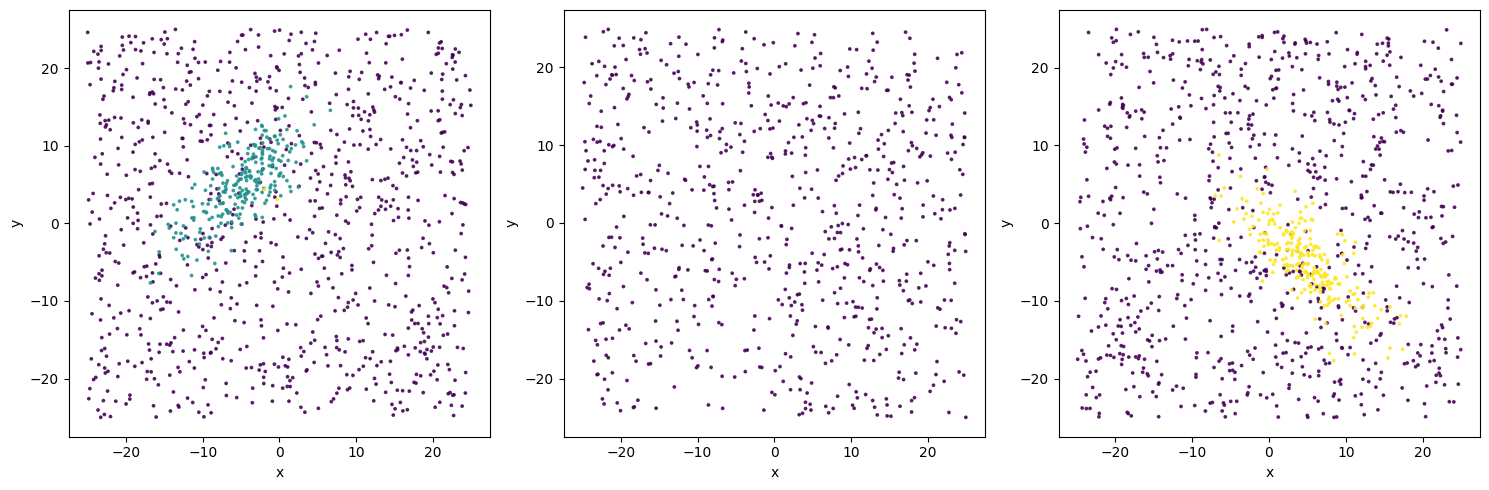

In [21]:
x_col, y_col = 'x', 'y'
plot_clusters(df, labels_ksets_opt, labels, K, x_col, y_col)

## Implement the Softmax Clustering Algorithm

from this paper https://arxiv.org/abs/1708.00316

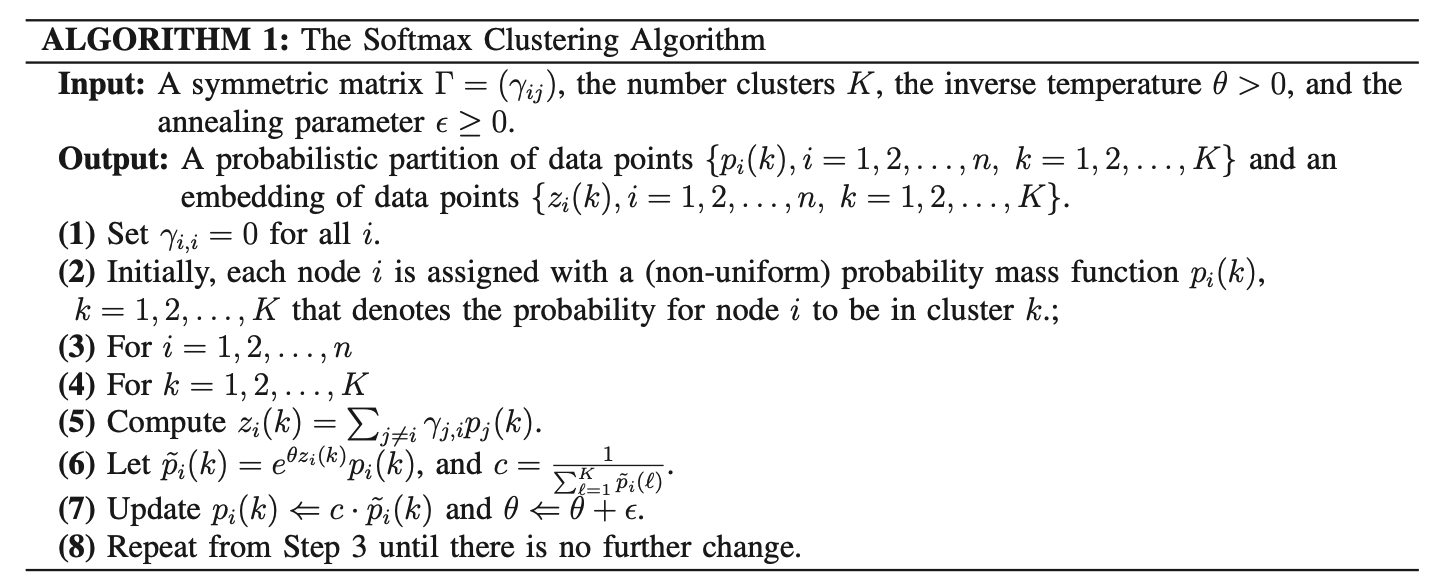

In [5]:
display(Image(filename='img/softmax_alg.png'))

In [23]:
def softmax_clustering(Gamma, K, theta=0.001, epsilon=0.0001, max_iter=250):
  
    start_time = time.time()
    
    # Set g[i,i] = 0 for all i
    np.fill_diagonal(Gamma, 0)
    n = Gamma.shape[0] #size

    np.random.seed(42)

    # Initialize each node i with (non-uniform) probability mass function pi(k)
    p_i = np.random.dirichlet(np.ones(K), size=n) 
    z = np.zeros((n, K))  # for covariance

    for iteration in range(max_iter):
        for i in range(n):
            for k in range(K):
                z[i, k] = np.sum(Gamma[i, :] * p_i[:, k])  # Compute covariance
        
  
        for i in range(n):
            p_t = np.exp(theta * z[i, :]) * p_i[i, :]  # Softmax function
            c = 1 / np.sum(p_t)  
            p_i[i, :] = c * p_t  # Update probability uisng softmax function

     
        theta += epsilon

        # If pi changes insignificantly, stop
        if iteration > 0 and np.allclose(p_i, prev_pi, atol=1e-6):
            break

        prev_pi = p_i.copy()

    execution_time = time.time() - start_time
    print(f'Execution time: {int(execution_time // 60)} minutes and {int(execution_time % 60)} seconds')
    print(f'Number of iterations: {iteration + 1}')

    return p_i, z

In [24]:
K = 6
p_i, z = softmax_clustering(G, K)

print("Probability partition of data points (pi):")
print(p_i)

print("Embedding of data points(z):")
print(z)

Execution time: 0 minutes and 14 seconds
Number of iterations: 166
Probability partition of data points (pi):
[[0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
Embedding of data points(z):
[[-5.51646377e+03  2.72618677e-67  9.11049816e-36  4.18421540e+03
   1.32183029e-67  1.30589196e+03]
 [ 2.26076800e+03  1.98862248e-67  6.64567139e-36 -3.14558494e+03
   9.64211791e-68  8.67160787e+02]
 [ 2.01106590e+03  1.04551775e-67  3.49395998e-36  6.44953234e+03
   5.06934095e-68 -8.48550051e+03]
 ...
 [ 4.38917955e+03 -6.81633256e-68 -2.27791382e-36 -1.40137289e+03
  -3.30499544e-68 -2.99564526e+03]
 [ 4.43137235e+03 -6.36843766e-68 -2.12823421e-36 -2.68806669e+03
  -3.08782725e-68 -1.75067244e+03]
 [ 2.56362386e+03 -1.34652222e-67 -4.49987078e-36 -3.23146585e+03
  -6.52880381e-68  6.61498536e+02]]


In [25]:
labels_softmax = np.argmax(p_i, axis=1)
labels_softmax

array([3, 0, 3, ..., 0, 0, 0])

In [26]:
unique_clusters = np.unique(labels_softmax)
unique_clusters

array([0, 3, 5])

In [27]:
# get clusters from probability
def get_clusters(p_i):

    cluster_labels = np.argmax(p_i, axis=1)
    _, relabeled_clusters = np.unique(cluster_labels, return_inverse=True)
    
    return relabeled_clusters


In [28]:
cluster_labels  = get_clusters(p_i)
cluster_labels 

array([1, 0, 1, ..., 0, 0, 0])

In [29]:
# get cluster labels and number of clusters
labels_softmax= get_clusters(p_i) 
unique_clusters = np.unique(labels_softmax)
num_clusters = len(unique_clusters)
print(num_clusters)

3


In [30]:
unique_clusters

array([0, 1, 2])

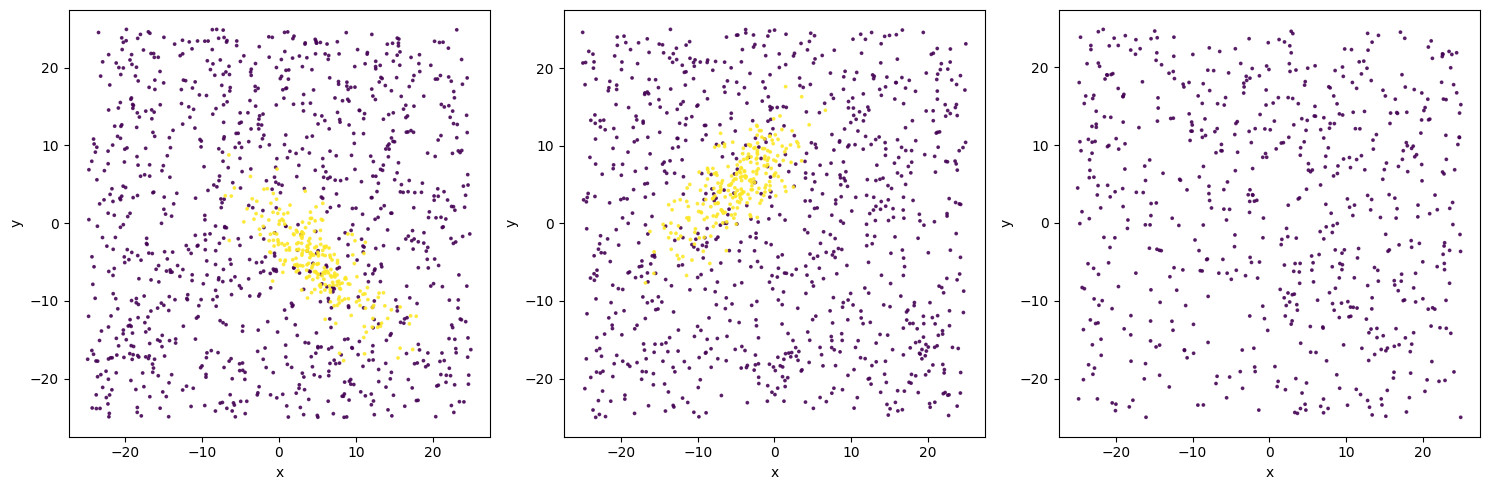

In [31]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'pmra', 'pmdec'
#x_col, y_col = 'vt_ra', 'vt_dec'
plot_clusters(df, labels_softmax, labels, num_clusters, x_col, y_col)

In [33]:
def softmax_clustering_optimized(Gamma, K, theta=0.001, epsilon=0.0001, max_iter=250):

    start_time = time.time()

    # Set g[i,i] = 0 for all i
    np.fill_diagonal(Gamma, 0)
    n = Gamma.shape[0]

    np.random.seed(42)

    # Initialize each node i with (non-uniform) probability mass function pi(k)
    p_i = np.random.dirichlet(np.ones(K), size=n) 
    z = np.zeros((n, K))  # for covariance

    for iteration in range(max_iter):
        # Compute covaraince (z)for all points and clusters
        z = Gamma @ p_i 

        p_t = np.exp(theta * z) * p_i  # Softmax function
        p_i = p_t / np.sum(p_t, axis=1, keepdims=True)  # Update probability uisng softmax function and normalize it (it must sum to 1)

        theta += epsilon

         # If pi changes insignificantly, stop
        if iteration > 0 and np.allclose(p_i, prev_pi, atol=1e-6):
            break

        prev_pi = p_i.copy()
        
    execution_time = time.time() - start_time
    print(f'Execution time: {int(execution_time // 60)} minutes and {int(execution_time % 60)} seconds')
    print(f'Number of iterations: {iteration + 1}')

    return p_i, z


In [34]:
K = 6  

p_i_opt, z_opt = softmax_clustering_optimized(G, K)

print("Probability partition of data points (pi):")
print(p_i_opt)

print("Embedding of data points(z):")
print(z_opt)


Execution time: 0 minutes and 0 seconds
Number of iterations: 166
Probability partition of data points (pi):
[[0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
Embedding of data points(z):
[[-5.51646377e+03  2.72618677e-67  9.11049816e-36  4.18421540e+03
   1.32183029e-67  1.30589196e+03]
 [ 2.26076800e+03  1.98862248e-67  6.64567139e-36 -3.14558494e+03
   9.64211791e-68  8.67160787e+02]
 [ 2.01106590e+03  1.04551775e-67  3.49395998e-36  6.44953234e+03
   5.06934095e-68 -8.48550051e+03]
 ...
 [ 4.38917955e+03 -6.81633256e-68 -2.27791382e-36 -1.40137289e+03
  -3.30499544e-68 -2.99564526e+03]
 [ 4.43137235e+03 -6.36843766e-68 -2.12823421e-36 -2.68806669e+03
  -3.08782725e-68 -1.75067244e+03]
 [ 2.56362386e+03 -1.34652222e-67 -4.49987078e-36 -3.23146585e+03
  -6.52880381e-68  6.61498536e+02]]


In [35]:
# get cluster labels and number of clusters
labels_softmax_opt= get_clusters(p_i_opt) 
unique_clusters = np.unique(labels_softmax_opt)
num_clusters = len(unique_clusters)
print(num_clusters)

3


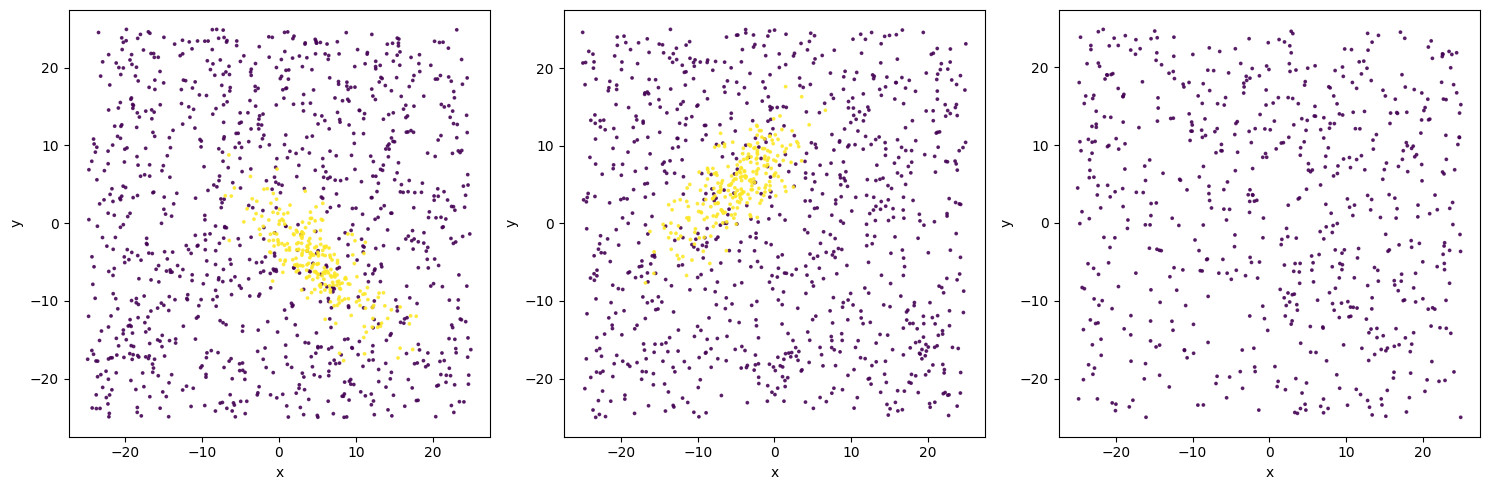

In [36]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'pmra', 'pmdec'
#x_col, y_col = 'vt_ra', 'vt_dec'
plot_clusters(df, labels_softmax_opt, labels, num_clusters, x_col, y_col)